<a href="https://colab.research.google.com/github/mamoan/NOVA_DL_home_exercise/blob/main/6_model_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 - Model inference
#   💻🧠+🖼️ --> 📝

Now, I will predict using the best models trained on the small and full datasets.



For the small dataset, the best model was the small model (Yolos) with an image size of 1056, and the autobatch option enabled.

F-score = 0.51,
Area under P-R curve = 0.481

For the full dataset, the best model was the small model (Yolos) with an image size of 640.

F-score = 0.43,
Area under P-R curve = 0.34

In [ ]:
import os
annotator_ID=8 # change this to your folder ID

path_to_ortho_predict1= "/content/drive/MyDrive/NOVA_course_home_exercise/data/orthomosaics/test_data/krakstad_202304_sun.tif"
path_to_ortho_predict2= "/content/drive/MyDrive/NOVA_course_home_exercise/data/orthomosaics/test_data/ortho_hobol_042222_mavic_sun.tif"
path_to_ortho_predict3= "/content/drive/MyDrive/NOVA_course_home_exercise/data/orthomosaics/test_data/galbyveien_20230504_sun.tif"
path_to_ortho_predict4= "/content/drive/MyDrive/NOVA_course_home_exercise/data/orthomosaics/test_data/braatan_40m_20230605_sun.tif"

path_to_tiles1="/content/drive/MyDrive/NOVA_course_home_exercise/data/tiles/10m_"+str(os.path.splitext( os.path.basename(path_to_ortho_predict1))[0])
path_to_tiles2="/content/drive/MyDrive/NOVA_course_home_exercise/data/tiles/10m_"+str(os.path.splitext( os.path.basename(path_to_ortho_predict2))[0])
path_to_tiles3="/content/drive/MyDrive/NOVA_course_home_exercise/data/tiles/10m_"+str(os.path.splitext( os.path.basename(path_to_ortho_predict3))[0])
path_to_tiles4="/content/drive/MyDrive/NOVA_course_home_exercise/data/tiles/10m_"+str(os.path.splitext( os.path.basename(path_to_ortho_predict4))[0])
# I don't have tiles for the other tif-files

path_to_model_small="/content/drive/MyDrive/NOVA_course_home_exercise/data/annotated_data/train/"+str(annotator_ID)+"/seedlings_YOLOs_img1056_autobatch_small/weights/best.pt"
path_to_model_full="/content/drive/MyDrive/NOVA_course_home_exercise/data/annotated_data/train/full_data/seedlings_YOLOs_img640_full/weights/best.pt"

In [ ]:
path_to_tiles2

'/content/drive/MyDrive/NOVA_course_home_exercise/data/tiles/10m_ortho_hobol_042222_mavic_sun'

## 5.2 Setup YOLOv8 and import other libraries

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.118 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.1/107.7 GB disk)


In [ ]:
# other libraries
!pip install geopandas
!pip install rasterio
!pip install folium matplotlib mapclassify
# general python packages
import os, glob, shutil
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
#import warnings
#warnings.filterwarnings("ignore")
#import sys

# geospatial packages
from osgeo import gdal, ogr, osr
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
path_osgeo_utils= "/usr/local/lib/python3.10/dist-packages/osgeo_utils" # defines path to gdal_retile.py

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Only related to the report: code for reading how many annotations were used in training and testing

This was checked here in order to write the home exercise report, and was unfortunately not checked earlier in the deep learning process.

In [ ]:
import pathlib
desktop = pathlib.Path("/content/drive/MyDrive/NOVA_course_home_exercise/data/annotated_data/train/8/train/labels")

# .iterdir() produces a generator
desktop.iterdir()

In [ ]:
odds = [0]

In [ ]:
print(odds)

In [ ]:
for item in desktop.iterdir():
    if item.is_file():
        print(item)
        with open(item, 'r') as fp:
            x = len(fp.readlines())
            odds += [x]
            # print('Total lines:', x) # 8

In [ ]:
print(sum(odds))

In [ ]:
for item in desktop.iterdir():
    if item.is_file():
        print(item)

In [ ]:
for item in desktop.iterdir():
    x = len(item.readlines())
    print('Total lines:', x) # 8

I can see that the number of validation plots are more than what I would expect if the 70/30 train/val had been sucessful. Now I have already made a bunch of models and I am short on time and GPU so I will continue with the evaluation anyways.

## 5.3 Write a function to do the tiling similarly to step 1 BUT with some overlap between the tiles

In [ ]:
# Params:
#   - input_ortho_path: path to orthophoto to predict on ("/content/drive/MyDrive/NOVA_course_deep_learning/data/orthomosaics/test_data/krakstad_202304_sun.tif")
#   - footprints_path: path to multipolygon layer of tile footprints ("/content/drive/MyDrive/NOVA_course_deep_learning/data/map_data/drone_acquisitions.geojson")
#   - tile_size_m: tile size in m
#   - buffer_size_m= size of overlap area around each tile in m (used for removing boundary effects)
# input_ortho_path=
# footprints_path=

def tile_orthomosaic(input_ortho_path,footprints_path, tile_size_m, buffer_size_m):
  # Define path to data
  path_data="/content/drive/MyDrive/NOVA_course_home_exercise/data"

  # read drone acquisition footprints
  footprints= gpd.read_file(footprints_path)
  # Get ortho name
  ortho_name=os.path.splitext(os.path.basename(input_ortho_path)) [0]

  # create output dir
  output_tiles_dir=path_data+"/tiles/"+str(tile_size_m)+"m_"+ortho_name
  if not os.path.exists(output_tiles_dir):
    print("Creating output folder..."+ output_tiles_dir)
    os.makedirs(output_tiles_dir)

  # get raster metadata
  # Get pixel resolution (in meters) and tile size in pixels
  src_ds = gdal.Open(input_ortho_path) # reads in the orthomosaic
  _, xres, _, _, _, yres  = src_ds.GetGeoTransform() # get pixel size in meters
  print("Ortho resolution: "+str(round(xres,4))+" m")
  # Get EPSG code
  proj = osr.SpatialReference(wkt=src_ds.GetProjection())
  EPSG_code= proj.GetAttrValue('AUTHORITY',1)
  print("EPSG code: "+str(EPSG_code))
  # get number of bands
  n_bands=src_ds.RasterCount
  print("Number of bands: "+str(n_bands))

  # Compute tile and buffer size in pixels
  tile_size_px= round(tile_size_m/abs(xres)) # calculate the tile size in pixels
  buffer_size_px= round(buffer_size_m/abs(xres)) # calculate the buffer size in pixels
  tileIndex_name=ortho_name+"_tile_index" # define name for output tile index shapefile

  # Run gdal_retile.py using (can take some minutes)
  command_retile = "python "+path_osgeo_utils+"/gdal_retile.py -targetDir " + output_tiles_dir + " " + input_ortho_path+ " -overlap " + str(buffer_size_px) + " -ps "+str(tile_size_px) + " " + str(tile_size_px) + " -of GTiff -tileIndex "+ tileIndex_name + " -tileIndexField ID"
  print(os.popen(command_retile).read()) ################################################################### SWITCH THIS ONE FOR TILING #########################################

  # cleanup tiles
  footprint_ortho= footprints[footprints['filename']==ortho_name]
  footprint_ortho_UU= footprint_ortho.geometry.unary_union
  # Load tiles shapefile
  tiles = gpd.read_file(output_tiles_dir+ "/"+ortho_name+"_tile_index.shp")
  tiles= tiles.to_crs(EPSG_code)

  # Select all tiles that are within the boundary polygon
  tiles_in = tiles[tiles.geometry.within(footprint_ortho_UU)]

  # Select all tiles that are not within the boundary polygon
  tiles_out= tiles.loc[~tiles['ID'].isin(tiles_in['ID']) ]
  print(str(len(tiles_out))+" tiles to be deleted")

  # delete tiles that are not within the footprint
  gtiffs_delete=[output_tiles_dir+ "/"+sub  for sub in tiles_out['ID']]
  for f in gtiffs_delete:
   if os.path.exists(f):
     os.remove(f)





There is an overlap of 1 m with neighbouring tiles.

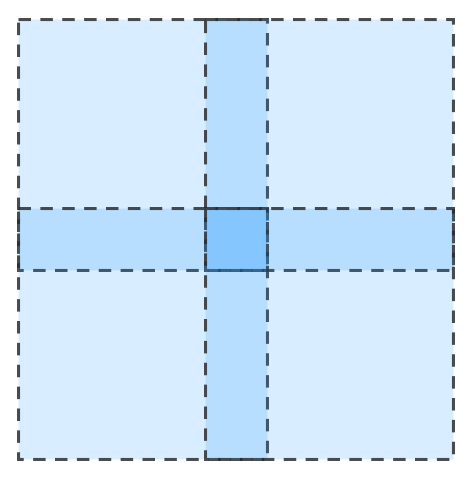

The overlap is needed to avoid having artifacts in the predictions due to non-detection on the edges of the images.

In [ ]:
path_to_ortho_predict4
# path_to_ortho_predict3

'/content/drive/MyDrive/NOVA_course_home_exercise/data/orthomosaics/test_data/braatan_20230605_sun.tif'

In [ ]:
tile_orthomosaic(input_ortho_path=path_to_ortho_predict1,
                 footprints_path= "/content/drive/MyDrive/NOVA_course_home_exercise/data/map_data/drone_acquisitions.geojson",
                 tile_size_m=10, # this could be changed, but I will leave it as is as I have no reason to set any other value
                 buffer_size_m=1) # this could also be changed, but I will leave it as it is

tile_orthomosaic(input_ortho_path=path_to_ortho_predict2,
                 footprints_path= "/content/drive/MyDrive/NOVA_course_home_exercise/data/map_data/drone_acquisitions.geojson",
                 tile_size_m=10, # this could be changed, but I will leave it as is as I have no reason to set any other value
                 buffer_size_m=1) # this could also be changed, but I will leave it as it is

tile_orthomosaic(input_ortho_path=path_to_ortho_predict3,
                 footprints_path= "/content/drive/MyDrive/NOVA_course_home_exercise/data/map_data/drone_acquisitions.geojson",
                 tile_size_m=10, # this could be changed, but I will leave it as is as I have no reason to set any other value
                 buffer_size_m=1) # this could also be changed, but I will leave it as it is

tile_orthomosaic(input_ortho_path=path_to_ortho_predict4,
                 footprints_path= "/content/drive/MyDrive/NOVA_course_home_exercise/data/map_data/drone_acquisitions.geojson",
                 tile_size_m=10, # this could be changed, but I will leave it as is as I have no reason to set any other value
                 buffer_size_m=1) # this could also be changed, but I will leave it as it is

## 5.4 Predict on the test data for ML metrics

Regarding the arguments, here are some interesting ones:
- `imgsz`  (default=640) image size to be fed to the model for inference. This should be the same size as it was fed to model training.
- `conf`	(default=0.25)	object confidence threshold for detection. I have defined this based on the the F1 curve in the trained model's folder:


- `save`	(default=False)	save images with results
- `save_txt`	(default=False)	save results as .txt file
- `save_conf`	(default=False)	save results with confidence scores

The test data that we should use for the evaluation with ML metrics have already been tiled. I don't know if it has been tiled with an overlap, but I will assume so since only the tiles images are available in that folder.

In [ ]:
path_to_tiles_ML = path_to_tiles1="/content/drive/MyDrive/NOVA_course_home_exercise/data/annotated_data/test/images"

## 5.4.1 Predict full model

In [ ]:
!yolo predict model=$path_to_model_full source=$path_to_tiles_ML imgsz=640 conf=0.220 project=$path_to_tiles_ML name=predict_tiles_ML save_txt=True save_conf=True save=True line_width=1

## 5.4.2 Predict small model

In [ ]:
!yolo predict model=$path_to_model_small source=$path_to_tiles_ML imgsz=1056 conf=0.471 project=$path_to_tiles_ML name=predict_tiles_ML_small save_txt=True save_conf=True save=True line_width=1

# 5.5 Predict on test data for remote sensing metrics

## 5.5.1 Predict full model

In [ ]:
path_to_tiles4

'/content/drive/MyDrive/NOVA_course_home_exercise/data/tiles/10m_braatan_40m_20230605_sun'

In [ ]:
# predict on test area 1
!yolo predict model=$path_to_model_full source=$path_to_tiles1 imgsz=640 conf=0.220 project=$path_to_tiles1 name=predict_tiles save_txt=True save_conf=True save=True line_width=1
# predict on test area 2
!yolo predict model=$path_to_model_full source=$path_to_tiles2 imgsz=640 conf=0.220 project=$path_to_tiles2 name=predict_tiles save_txt=True save_conf=True save=True line_width=1
# predict on test area 3
!yolo predict model=$path_to_model_full source=$path_to_tiles3 imgsz=640 conf=0.220 project=$path_to_tiles3 name=predict_tiles save_txt=True save_conf=True save=True line_width=1
# predict on test area 4
!yolo predict model=$path_to_model_full source=$path_to_tiles4 imgsz=640 conf=0.220 project=$path_to_tiles4 name=predict_tiles save_txt=True save_conf=True save=True line_width=1

## 5.5.2 Predict small model

In [ ]:
# predict on test area 1
!yolo predict model=$path_to_model_small source=$path_to_tiles1 imgsz=1056 conf=0.471 project=$path_to_tiles1 name=predict_tiles_small save_txt=True save_conf=True save=True line_width=1
# predict on test area 2
!yolo predict model=$path_to_model_small source=$path_to_tiles2 imgsz=1056 conf=0.471 project=$path_to_tiles2 name=predict_tiles_small save_txt=True save_conf=True save=True line_width=1
# predict on test area 3
!yolo predict model=$path_to_model_small source=$path_to_tiles3 imgsz=1056 conf=0.471 project=$path_to_tiles3 name=predict_tiles_small save_txt=True save_conf=True save=True line_width=1
# predict on test area 4
!yolo predict model=$path_to_model_small source=$path_to_tiles4 imgsz=1056 conf=0.471 project=$path_to_tiles4 name=predict_tiles_small save_txt=True save_conf=True save=True line_width=1

# Now I will convert the predictions from image to map space in postprocessing